In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Flatten

<ipython-input-2-e2d91ad21a0c>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
<ipython-input-2-e2d91ad21a0c>:13: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])


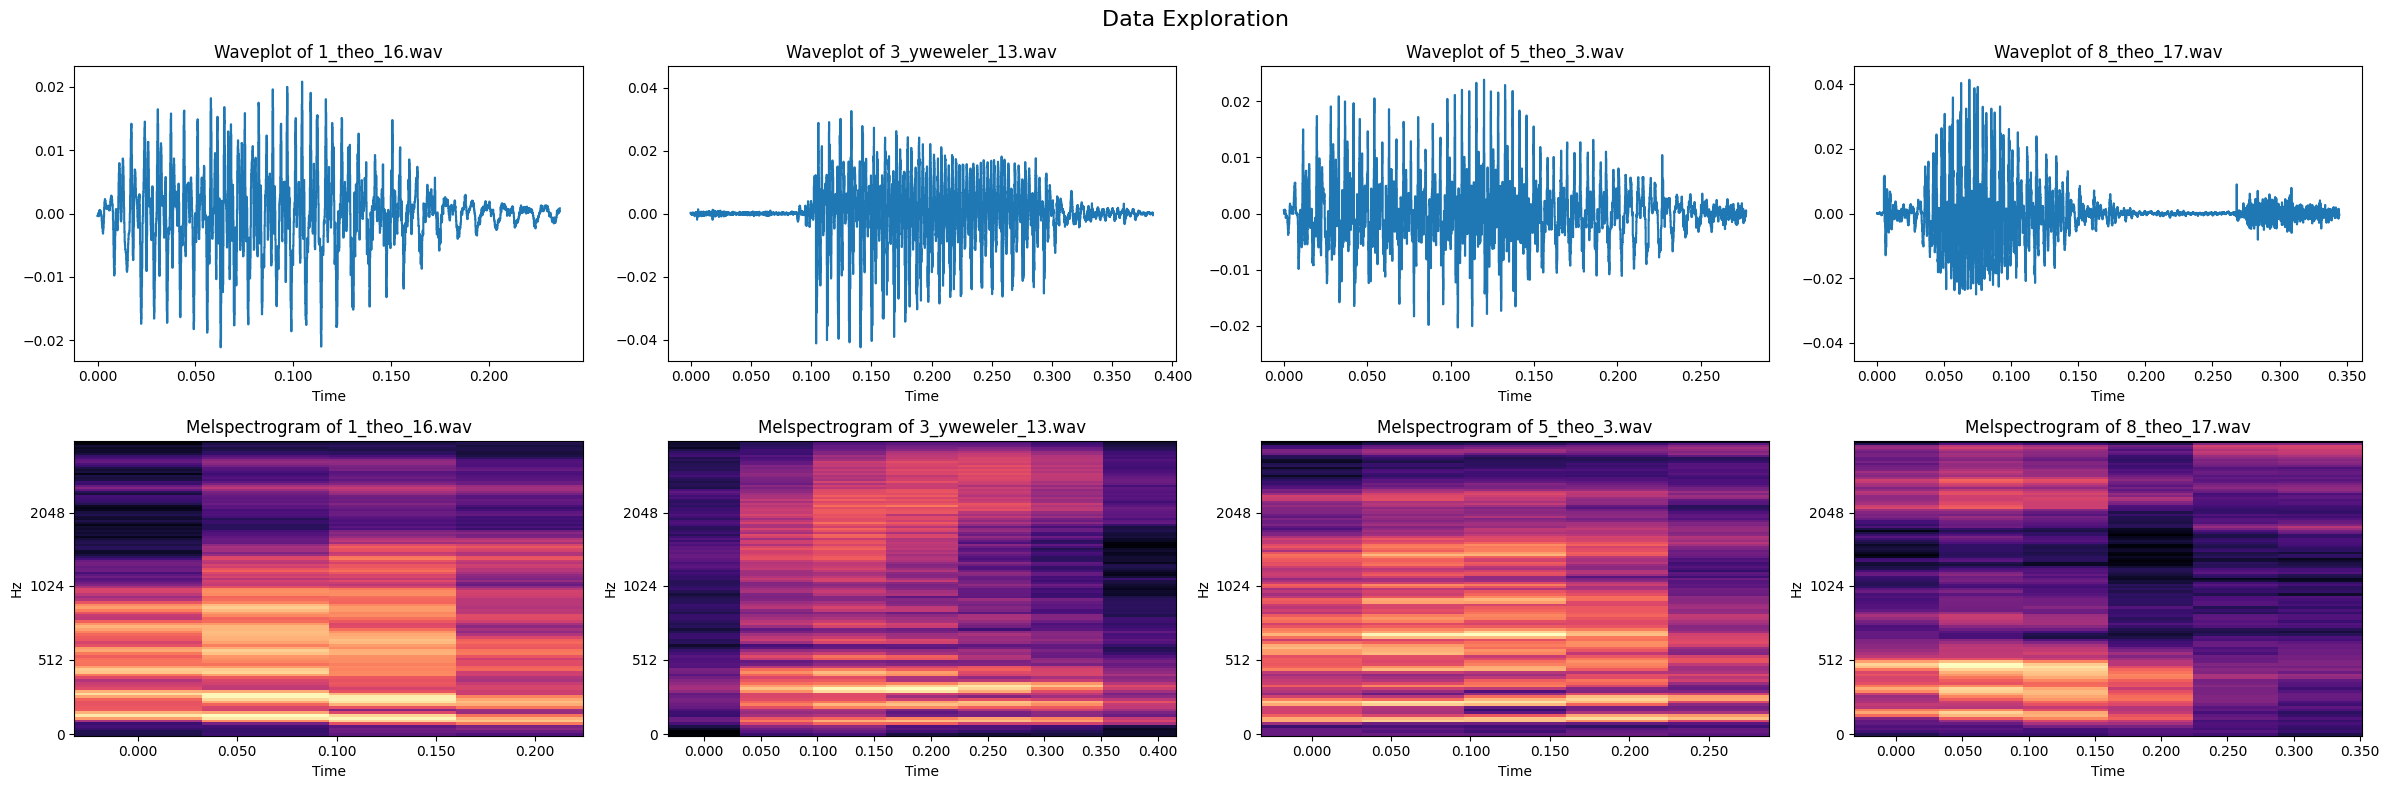

In [ ]:
visualize_digits = [1, 3, 5, 8]

description = pd.read_csv('/content/drive/MyDrive/PROJECT/rec/train.csv')
fig, axs = plt.subplots(nrows=2, ncols=(len(visualize_digits)))
axs = axs.flatten()
fig.suptitle('Data Exploration', fontsize=16)
fig.set_size_inches(24, 8)
for i, digit in enumerate(visualize_digits):
    # Select random file for selected digit
    rand_file = np.random.choice(description[description['label'] == digit]['file_name'])
    # Load audio and plot waveform and melspectrogram
    audio, sr = librosa.load(os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', rand_file), sr=None)
    librosa.display.waveshow(y=audio, sr=sr, x_axis='time', ax=axs[i])
    axs[i].set(title=f'Waveplot of {rand_file}')
    mels_db = librosa.power_to_db(S=librosa.feature.melspectrogram(y=audio, sr=sr), ref=1.0)
    librosa.display.specshow(data=mels_db, sr=sr, x_axis='time', y_axis='mel', ax=axs[i+len(visualize_digits)])
    axs[i+len(visualize_digits)].set(title=f'Melspectrogram of {rand_file}')
plt.tight_layout()
plt.show()

In [ ]:
feature_list = []
label_list = []
# Iterate over all files in given source path
print('Preparing feature dataset and labels.')
for file in tqdm(os.listdir('/content/drive/MyDrive/PROJECT/rec/recordings')):
    # Skip if it's not a wav file
    if not file.endswith('.wav'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join('/content/drive/MyDrive/PROJECT/rec/recordings', file)
    audio, sr = librosa.load(path=audio_path, sr=None)
    audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    mels = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=2048, hop_length=512)
    mels_db = librosa.power_to_db(S=mels, ref=1.0)
    feature_list.append(mels_db.reshape((128, 16, 1)))
    label_list.append(file[0])
features = np.array(feature_list)
labels = np.array(label_list)

Preparing feature dataset and labels.


100%|██████████| 3020/3020 [02:47<00:00, 17.98it/s]


In [ ]:
# Set parameters for data splitting and training
TEST_SIZE = 0.3
BATCH_SIZE = 64
EPOCHS = 20
# Encode Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=TEST_SIZE, random_state=42)

# Reshape features for LSTM
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(64, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
model_lstm.add(LSTM(64, return_sequences=True))
model_lstm.add(LSTM(32))
model_lstm.add(Dense(10, activation='softmax'))

model_lstm.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Display the model summary
print(model_lstm.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 128, 64)           20736     
                                                                 
 lstm_7 (LSTM)               (None, 128, 64)           33024     
                                                                 
 lstm_8 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 10)                330       
                                                                 
Total params: 66506 (259.79 KB)
Trainable params: 66506 (259.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Epoch 1/20
24/24 [==============================] - 15s 330ms/step - loss: 2.1947 - accuracy: 0.1961 - val_loss: 2.0558 - val_accuracy: 0.2488
Epoch 2/20
24/24 [==============================] - 9s 364ms/step - loss: 1.9330 - accuracy: 0.3029 - val_loss: 1.8291 - val_accuracy: 0.3528
Epoch 3/20
24/24 [==============================] - 7s 277ms/step - loss: 1.6897 - accuracy: 0.3942 - val_loss: 1.5645 - val_accuracy: 0.4283
Epoch 4/20
24/24 [==============================] - 8s 341ms/step - loss: 1.4647 - accuracy: 0.4848 - val_loss: 1.5222 - val_accuracy: 0.4772
Epoch 5/20
24/24 [==============================] - 7s 292ms/step - loss: 1.3447 - accuracy: 0.5287 - val_loss: 1.3469 - val_accuracy: 0.5417
Epoch 6/20
24/24 [==============================] - 10s 428ms/step - loss: 1.2116 - accuracy: 0.5794 - val_loss: 1.2288 - val_accuracy: 0.5764
Epoch 7/20
24/24 [==============================] - 6s 257ms/step - loss: 1.2215 - accuracy: 0.5693 - val_loss: 1.1070 - val_accuracy: 0.6315
Epoc

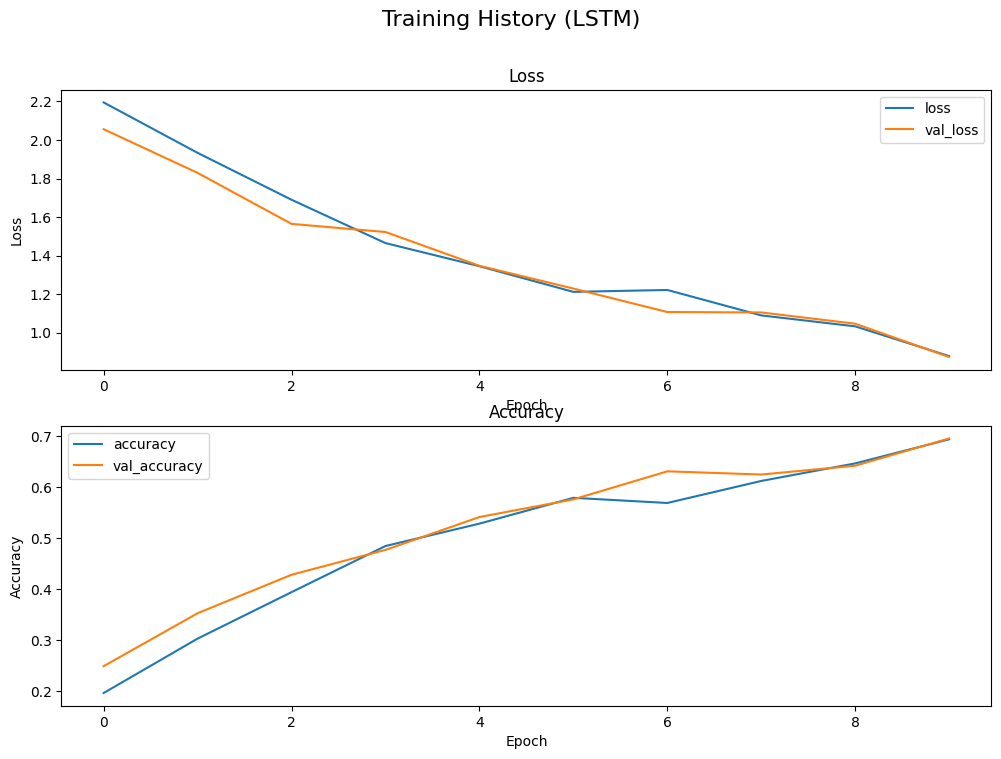

In [ ]:
# Train the model
early_stopping_lstm = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_lstm = model_lstm.fit(
    x=X_train_lstm,
    y=y_train,
    validation_split=TEST_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping_lstm]
)

# Plot the training history up to epoch 10
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History (LSTM)', fontsize=16)
axs[0].plot(history_lstm.epoch[:10], history_lstm.history['loss'][:10], history_lstm.history['val_loss'][:10])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history_lstm.epoch[:10], history_lstm.history['accuracy'][:10], history_lstm.history['val_accuracy'][:10])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model_lstm.evaluate(X_test_lstm, y_test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

29/29 [==============================] - 2s 54ms/step - loss: 0.8042 - accuracy: 0.7185
Test Accuracy: 71.85%
